In [1]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import time

In [2]:
arizona = ZipFile('az2020.pl.zip')
import csv
import codecs

with codecs.open('geolabels.csv',encoding='latin-1') as file:
    geolabels = list(csv.reader(file))[0]
with arizona.open('azgeo2020.pl','r') as file:
    geo = pd.read_csv(file,sep='|',index_col=False,encoding='latin-1',names=geolabels, keep_default_na=False, low_memory=False)
with codecs.open('pl1labels.csv',encoding='utf-8') as file:
    pl1labels = list(csv.reader(file))[0]
with arizona.open('az000012020.pl','r') as file:
    az1 = pd.read_csv(file,sep='|',index_col=False,encoding='utf-8',names=pl1labels, keep_default_na=False, low_memory=False)
    
with codecs.open('pl2labels.csv',encoding='latin-1') as file:
    pl2labels = list(csv.reader(file))[0]    
with arizona.open('az000022020.pl','r') as file:
    az2 = pd.read_csv(file,sep='|',index_col=False,encoding='latin-1',names=pl2labels, keep_default_na=False, low_memory=False)
    
with codecs.open('pl3labels.csv',encoding='latin-1') as file:
    pl3labels = list(csv.reader(file))[0]    
with arizona.open('az000032020.pl','r') as file:
    az3 = pd.read_csv(file,sep='|',index_col=False,encoding='latin-1',names=pl3labels, keep_default_na=False, low_memory=False)    

In [3]:
census_data = pd.concat([geo, az1, az2, az3],axis=1)
alignment_cols = 'COUNTY TRACT BLKGRP'.split()
census_data[alignment_cols] = census_data[alignment_cols].apply(lambda x: pd.to_numeric(x, downcast='integer'))
# census_data = census_data[census_data['COUNTY']!=13]
# census_data = census_data[census_data['COUNTY']!=21]
census_data = census_data[census_data['POP100'] > 0]

# Generate block data

In [4]:
# Do some computations
block_data = census_data[census_data['SUMLEV']==750]
group_data = census_data[census_data['SUMLEV']==150]
# This is stupid
# block_data = block_data.astype({'COUNTY': int, 'TRACT': int, 'BLKGRP': int})
# group_data = group_data.astype({'COUNTY': int, 'TRACT': int, 'BLKGRP': int})
nonnumeric_cols = 'COUNTY COUSUB PLACE AIANHH AITS AIHHTLI SDELM SDSEC SDUNI MEMI CSA METDIV CBSAPCI'
tract_class_cols = {c:{a:b for b,a in enumerate(set(block_data[c]))} for c in nonnumeric_cols.split()}
uniq = [k for k,v in tract_class_cols.items() if len(v) < 2 ]
for k in uniq:
    tract_class_cols.pop(k)
print('N=', len(group_data))
cols = 1
for cname, c in tract_class_cols.items():
    print(cname,len(c))
    cols += len(c)
    for ci in c:
        assert len(block_data[block_data[cname]==ci]) > 0, (cname, ci)
print('D=', cols)
    
def row_length():
    idx = 0
    # Classifications
    for c,dc in tract_class_cols.items():
        idx += len(dc)
    # Geographic numerics
    idx += 4
    # Demographics
    # All
    idx += 8
    # Hispanic
    idx += 9
    # 18+
    idx += 9
    # Hispanic
    idx += 9 
    # Housing
    # Group quarters
    idx += 9
    return idx

def row_titles():
    titles = []
    # Classifications
    for c,dc in tract_class_cols.items():
        for dcname in dc:
            titles.append(c + ' ' + str(dcname))
            
    # Geographic numerics
    titles.extend(['AREA', 'POP DENSITY', 'HOUSING DENSITY', 'LATITUDE', 'LONGITUDE'])
    # Demographics
    # All
    titles.extend(['% WHITE', '% BLACK', '% INDIAN', '% ASIAN', '% PI/AK', '% OTHER', '% TWO'])
    # Hispanic
    titles.extend(['% HISPANIC', '% WHITE (HISP)', '% BLACK (HISP)', '% INDIAN (HISP)', '% ASIAN (HISP)', '% PI/AK (HISP)', '% OTHER (HISP)', '% TWO (HISP)'])
    # 18+
    titles.extend(['% 18+', '% WHITE (18+)', '% BLACK (18+)', '% INDIAN (18+)', '% ASIAN (18+)', '% PI/AK (18+)', '% OTHER (18+)', '% TWO (18+)'])
    # Hispanic
    titles.extend(['% HISPANIC&18+', '% WHITE (HISP&18+)', '% BLACK (HISP&18+)', '% INDIAN (HISP&18+)', '% ASIAN (HISP&18+)', '% PI/AK (HISP&18+)', '% OTHER (HISP&18+)', '% TWO (HISP&18+)'])
    # Housing
    # Group quarters
    titles.extend(['% CORRECTIONAL', '% JUVENILE', '% NURSING', '% OTHER GROUP1', '% COLLEGE', '% MILITARY', '% OTHER GROUP2'])
    return titles

def title_types():
    titles = {}
    # Classifications
    for c,dc in tract_class_cols.items():
        for dcname in dc:
            titles[c + ' ' + str(dcname)]= 'BOOL'
    nums = [] 
    # Geographic numerics
    nums.extend(['AREA', 'POP DENSITY', 'HOUSING DENSITY', 'LATITUDE', 'LONGITUDE'])
    for n in nums:
        titles[n] = 'NUM'
    nums = []
    # Demographics
    # All
    nums.extend(['% WHITE', '% BLACK', '% INDIAN', '% ASIAN', '% PI/AK', '% OTHER', '% TWO'])
    # Hispanic
    nums.extend(['% HISPANIC', '% WHITE (HISP)', '% BLACK (HISP)', '% INDIAN (HISP)', '% ASIAN (HISP)', '% PI/AK (HISP)', '% OTHER (HISP)', '% TWO (HISP)'])
    # 18+
    nums.extend(['% 18+', '% WHITE (18+)', '% BLACK (18+)', '% INDIAN (18+)', '% ASIAN (18+)', '% PI/AK (18+)', '% OTHER (18+)', '% TWO (18+)'])
    # Hispanic
    nums.extend(['% HISPANIC&18+', '% WHITE (HISP&18+)', '% BLACK (HISP&18+)', '% INDIAN (HISP&18+)', '% ASIAN (HISP&18+)', '% PI/AK (HISP&18+)', '% OTHER (HISP&18+)', '% TWO (HISP&18+)'])
    # Housing
    # Group quarters
    nums.extend(['% CORRECTIONAL', '% JUVENILE', '% NURSING', '% OTHER GROUP1', '% COLLEGE', '% MILITARY', '% OTHER GROUP2'])
    
    for n in nums:
        titles[n] = 'PCT'
    
    return titles    


def get_info(blocks):
    row_info = np.zeros(row_length())
#     blocks = census_data[(census_data['SUMLEV']==750) & (census_data['BLKGRP']==blk['BLKGRP']) & (census_data['TRACT']==blk['TRACT'])]
    total_pop = 0
    rts = row_titles()
    for _,blk in blocks.iterrows():
        row_data = np.zeros( row_length())
        idx = 0
        # Classifications
        block_pop = blk['POP100']  
        total_pop += block_pop
        for c,dc in tract_class_cols.items():
    #         print(idx, ': ', c)
            assert rts[idx + dc[blk[c]]] == c + ' ' + str(blk[c]), (rts[idx + dc[blk[c]]], c + ' ' + str(blk[c]))
            row_data[idx+dc[blk[c]]] = 1
            idx += len(dc)

        # Geographic numerics
        block_area = blk['AREALAND']+blk['AREAWATR']
        row_data[idx] += blk['AREALAND'] / block_area # % land

        row_data[idx+1] = block_pop / block_area # pop density
        block_dens = block_pop / block_area
        row_data[idx+2] = blk['HU100'] / max(1,blk['POP100']) # housing density
        row_data[idx+3] = blk['INTPTLAT']
        row_data[idx+4] = blk['INTPTLON']
        if row_data[idx+4] < -1000:
            print('wtf')
            print(blk)
    #     print(idx)
        idx += 4
        # Demographics
        # All
        block_pop = max(1,blk['P0010001'])
        row_data[idx+1] = blk['P0010003']  / block_pop # % white
        row_data[idx+2] = blk['P0010004']  / block_pop # % black
        row_data[idx+3] = blk['P0010005']  / block_pop # % indian/native
        row_data[idx+4] = blk['P0010006']  / block_pop # % asian
        row_data[idx+5] = blk['P0010007']  / block_pop # % island
        row_data[idx+6] = blk['P0010008']  / block_pop # % other
        row_data[idx+7] = blk['P0010010']  / block_pop # % two
        row_data[idx+8] = (blk['P0010009']-blk['P0010010'])  / block_pop # % >2
        idx += 8
    #     print(idx)
        # Hispanic
        hisp_pop = blk['P0020003']
        row_data[idx+1] = hisp_pop  / block_pop # % hispanic
        if hisp_pop == 0:
            hisp_pop = 1
        row_data[idx+2] = blk['P0020005']  / hisp_pop # % white
        row_data[idx+3] = blk['P0020006']  / hisp_pop # % black
        row_data[idx+4] = blk['P0020007']  / hisp_pop # % indian/native
        row_data[idx+5] = blk['P0020008']  / hisp_pop # % asian
        row_data[idx+6] = blk['P0020009']  / hisp_pop # % island
        row_data[idx+7] = blk['P0020010']  / hisp_pop # % other
        row_data[idx+8] = blk['P0020012']  / hisp_pop # % two
        row_data[idx+9] = (blk['P0020011']-blk['P0020012'])  / hisp_pop # % >2
        idx += 9
    #     print(idx)
        # 18+
        adult_pop = blk['P0030001']
        row_data[idx+1] = adult_pop / block_pop # % adult
        if adult_pop == 0:
            adult_pop = 1
        row_data[idx+2] = blk['P0030003']  / adult_pop # % white
        row_data[idx+3] = blk['P0030004']  / adult_pop # % black
        row_data[idx+4] = blk['P0030005']  / adult_pop # % indian/native
        row_data[idx+5] = blk['P0030006']  / adult_pop # % asian
        row_data[idx+6] = blk['P0030007']  / adult_pop # % island
        row_data[idx+7] = blk['P0030008']  / adult_pop # % other
        row_data[idx+8] = blk['P0030010']  / adult_pop # % two
        row_data[idx+9] = (blk['P0030009']-blk['P0030010'])  / adult_pop # % >2
        idx += 9
    #     print(idx)
        # Hispanic
        hispadult_pop = blk['P0040003']
        row_data[idx+1] = hispadult_pop  / block_pop # % hispanic
        if hispadult_pop == 0:
            hispadult_pop = 1
        row_data[idx+2] = blk['P0040005']  / hispadult_pop # % white
        row_data[idx+3] = blk['P0040006']  / hispadult_pop # % black
        row_data[idx+4] = blk['P0040007']  / hispadult_pop # % indian/native
        row_data[idx+5] = blk['P0040008']  / hispadult_pop # % asian
        row_data[idx+6] = blk['P0040009']  / hispadult_pop # % island
        row_data[idx+7] = blk['P0040010']  / hispadult_pop # % other
        row_data[idx+8] = blk['P0040012']  / hispadult_pop # % two
        row_data[idx+9] = (blk['P0040011']-blk['P0040012'])  / hispadult_pop # % >2
        idx += 9 

        # Housing
        row_data[idx+1] = blk['H0010002'] / max(1,blk['H0010001'])
    #     print(idx)
        # Group quarters
        row_data[idx+2] = blk['P0050003']  / block_pop # % correctional
        row_data[idx+3] = blk['P0050004']  / block_pop # % juvenile
        row_data[idx+4] = blk['P0050005']  / block_pop # % nursing
        row_data[idx+5] = blk['P0050006']  / block_pop # % other
        row_data[idx+6] = blk['P0050008']  / block_pop # % college
        row_data[idx+7] = blk['P0050009']  / block_pop # % military
        row_data[idx+8] = blk['P0050010']  / block_pop # % other
#     print(idx+8)
        row_info += blk['POP100'] * row_data
        
    if total_pop == 0:
        return row_info
    else:
        return row_info / total_pop


def progress_bar(i,n,k):
    print('[%s%d%s] - %10d' % ( '|'*max(0, int(k*i/n)-1), int(10*((k*i)/n % 1)), '.'*(k - max(0, int(k*i/n)-1)), i), end='\r')

N= 4755
COUNTY 15
COUSUB 80
PLACE 466
AIANHH 22
AITS 101
AIHHTLI 3
SDELM 105
SDSEC 16
SDUNI 99
MEMI 3
CSA 3
CBSAPCI 3
D= 917


# create matrix

In [5]:
# numeric_cols = 'AREALAND AREAWATR POP100 HU100 INTPTLAT INTPTLON'
# pop_cols1 = 'P0010001 P0010003 P0010004 P0010005 P0010006 P0010007 P0010008 P0010010 P0010009'
# pop_cols2 = 'P0020001 P0020005 P0020006 P0020007 P0020008 P0020009 P0020010 P0020012 P0020011'
# pop_cols3 =  'P0030001 P0030003 P0030004 P0030005 P0030006 P0030007 P0030008 P0030010 P0030009'
# pop_cols4 =  'P0040001 P0040005 P0040006 P0040007 P0040008 P0040009 P0040010 P0040012 P0040011'
tm=time.time()
rlen = row_length()
group_mat = np.zeros((group_data.shape[0], rlen))
counties = set(group_data['COUNTY'])
geocode_order = []
populations = []
for c in counties:
    county_blocks = block_data[block_data['COUNTY']==c]
    county_groups = group_data[group_data['COUNTY']==c]
    tracts = set(county_groups['TRACT'])
    for t in tracts:
        tract_blocks = county_blocks[county_blocks['TRACT']==t]
        tract_groups = county_groups[county_groups['TRACT']==t]
        for _,g in tract_groups.iterrows():
            progress_bar(len(geocode_order),len(group_data),50)
            group_blocks = tract_blocks[tract_blocks['BLKGRP']==g['BLKGRP']]
            group_mat[len(geocode_order)] = get_info(group_blocks)
            geocode_order.append(g['GEOCODE'])
            populations.append(g['POP100'])
            if group_mat.min() < -1000:
                print('wtf')
                raise Exception()
print()
print(time.time() - tm)

[||||||||||||||||||||||||||||||||||||||||||||||||9..] -       4754
464.97530341148376


## Do the clustering

In [6]:

print(np.isnan(group_mat).sum())
print(np.isinf(group_mat).sum())
group_std = group_mat / np.std(group_mat, axis=0)
print(np.isnan(group_std).sum())
print(np.isinf(group_std).sum())
# group_std[np.isnan(group_std)] = 0
# group_std[np.isinf(group_std)] = 0

0
0
0
0


In [7]:
std = np.std(group_mat, axis=0)
print(std.shape)
print(np.isnan(std).sum())
print(min(std))
print(sorted(std)[:20])
print(sum(std==0))
ag = np.argmin(std)
rt = row_titles()
mn = np.mean(group_mat, axis=0)
print(min(mn))
print(sorted(mn)[:20])
print(sum(mn==0))
print(rt[ag])

(964,)
0
5.486329717548974e-06
[5.486329717548974e-06, 1.7282919479713124e-05, 1.8614081442209532e-05, 2.007764398732027e-05, 2.4217736022515507e-05, 3.1016833034183276e-05, 3.840430802284194e-05, 5.241097389210784e-05, 6.988129852280789e-05, 7.132228632813493e-05, 7.838037537016824e-05, 8.554790232141982e-05, 8.735162315351104e-05, 9.524052179626686e-05, 0.00010223527222194887, 0.00010385224310460702, 0.00010972659435097025, 0.00010980506940793587, 0.00011521292406852685, 0.0001215845248782143]
0
-111.8839808029403
[-111.8839808029403, 7.957054187141162e-08, 2.506614328559486e-07, 2.699678333326584e-07, 3.512399869163105e-07, 4.069179312879994e-07, 4.4985014367088965e-07, 5.569937930998813e-07, 7.601383451788225e-07, 1.0135177935717635e-06, 1.0344170443283508e-06, 1.1367834711683293e-06, 1.240737121924135e-06, 1.2668972419647044e-06, 1.3813132490386924e-06, 1.4827610493499947e-06, 1.5062126565166762e-06, 1.5914108374282323e-06, 1.5925489941062417e-06, 1.670981379299644e-06]
0
AITS 261

In [8]:
group_pops = np.array(populations)
group_codes = np.array(geocode_order)
group_mat_nz = group_mat[group_pops > 0]
print(group_mat_nz.shape)
group_codes_nz = group_codes[group_pops > 0]
group_pops_nz = group_pops[group_pops > 0]

(4755, 964)


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

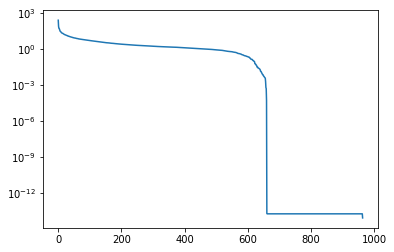

In [9]:
group_nml_nz = (group_mat_nz - np.min(group_mat_nz, axis=0)) / (np.max(group_mat_nz, axis=0) - np.min(group_mat_nz, axis=0))
u,s,vt = np.linalg.svd(group_nml_nz, full_matrices=False)
plt.plot(s)
plt.yscale('log')
plt.show()

## WAG code

In [10]:
class Tree:
    def __init__(self, members, population, vector, left=None, right=None, up=None):
        self.members = members
        self.population = population
        self.vector = vector
        self.left = left
        self.right = right
        self.up = up
        self.side = None
    def merge(self, other):
        vector = (self.vector * self.population + other.vector * other.population) / (self.population + other.population)
        up = Tree(self.members.union(other.members), self.population + other.population, vector, left=self, right=other)
        self.up = up
        self.side = 'left'
        other.up = up
        other.side = 'right'
        return up
    def child(self, other):
        if self.left is not None:
            self.left = other
        elif self.right is not None:
            self.right = other
        else:
            raise Exception()
        other.up = self
    def remove(self):
        if self.up is not None:
            if self.side == 'left':
                self.up.left = None
            else:
                self.up.right = None
            if self.up.members == self.members:
                assert self.up.left == None, self.side
                assert self.up.right == None, self.side
                assert self.up.population == self.population
                self.up.remove()
            else:
                self.up.vector = (self.up.population * self.up.vector - self.population * self.vector) / (self.up.population - self.population)
                self.up.members.difference_update(self.members)
                self.up.population -= self.population
            self.side = None
            self.up = None

from multiprocessing import Pool, RawArray
var_dict = {}

def init_worker(populations, pop_shape, matrix, matrix_shape):
    var_dict['populations'] = populations
    var_dict['pop_shape'] = pop_shape
    var_dict['matrix'] = matrix
    var_dict['matrix_shape'] = matrix_shape
    
def worker_func(tup):
    populations = np.frombuffer(var_dict['populations']).reshape(var_dict['pop_shape'])
    matrix = np.frombuffer(var_dict['matrix']).reshape(var_dict['matrix_shape'])
    i,j = tup
    return i,j, 4*populations[i]*populations[j]*np.square(matrix[i] - matrix[j]).sum() / \
                     ((populations[i]+1)*(populations[j]+1))

def prepare_data(array):
    X = RawArray('d', array.size)
    X_np = np.frombuffer(X).reshape(array.shape)
    np.copyto(X_np, array)
    return X
    
class WeightedAgglomerativeClustering:
    def __init__(self, n_clusters=1):
        self.n_clusters_ = n_clusters
        self.labels_ = None
        self.children_ = None
        self.population_ = None
        self.tree = None
    def fit(self, matrix, populations, processes=1):
        pop_limit = sum(populations) / self.n_clusters_
        clusters = {i: Tree(members={i}, population=populations[i], vector=matrix[i]) for i in range(len(matrix))}
        if processes > 1:
            pop_shape = populations.shape
            matrix_shape = matrix.shape
            pop_mp = prepare_data(populations)
            mat_mp = prepare_data(matrix)
            with Pool(processes=processes, initializer=init_worker, initargs=(pop_mp, pop_shape, mat_mp, matrix_shape)) as pool:
                dists = pool.map(worker_func, [(i,j) for i in range(len(matrix)) for j in range(i+1,len(matrix))])
            distances = {(i,j): d for i,j,d in dists}
        else:
            distances = {(i,j): \
                     4*populations[i]*populations[j]*np.square(matrix[i] - matrix[j]).sum() / \
                     ((populations[i]+1)*(populations[j]+1)) for i in range(len(matrix)) for j in range(i+1,len(matrix))}
        idx = len(clusters)
        children = []
        
        while len(clusters) > self.n_clusters_:
            print('{0: < 10}'.format(len(clusters)), end='\r')
            # Find the closest pair of clusters that don't exceed the pop_limit
            i,j = min(distances.items(), key=lambda x: x[1])[0]
            if clusters[i].population + clusters[j].population > pop_limit:
                break
            joined = clusters[i].merge(clusters[j])
            for c2 in clusters:
                if c2 == i or c2 == j:
                    continue
                total_pop = clusters[i].population + clusters[j].population + clusters[c2].population
                
                if total_pop > pop_limit:
                    distances[(c2,idx)] = np.inf
                else:
                    distances[(c2,idx)] = (clusters[i].population + clusters[c2].population)*distances[tuple(sorted([i,c2]))] / total_pop  +  (clusters[j].population + clusters[c2].population)*distances[tuple(sorted([j,c2]))] / total_pop -  clusters[c2].population *distances[tuple(sorted([i,j]))] / total_pop
            clusters[idx] = joined   
            children.append((i,j,idx,joined.population, distances[(i,j)]))
            to_remove = []
            for k in distances:
                if i in k or j in k:
                    to_remove.append(k)
            for k in to_remove:
                distances.pop(k)
            clusters.pop(i)
            clusters.pop(j)
            idx += 1
        self.children_ = children
        self.population_ = populations
        return clusters
    
def copy_tree(tree):
    new_tree = Tree(set([m for m in tree.members]), tree.population, tree.vector.copy())
    if tree.left is not None:
        new_tree.left = copy_tree(tree.left)
        new_tree.left.up = new_tree
    if tree.right is not None:
        new_tree.right = copy_tree(tree.right)
        new_tree.right.up = new_tree
    new_tree.side = tree.side
    return new_tree

def tree_distance(t1, t2):
    if t1.left is not None and t1.right is not None:
        if hasattr(t1,'sibling_distance') and t1.sibling_distance is not None:
            sib_dist = t1.sibling_distance
        else:
            t1.sibling_distance = tree_distance(t1.left, t1.right)
            sib_dist = t1.sibling_distance
        total_pop = t1.population + t2.population
        return (t1.left.population + t2.population) * tree_distance(t1.left, t2) / total_pop \
                + (t1.right.population + t2.population) * tree_distance(t1.right, t2) / total_pop \
                + (t1.population) * sib_dist / total_pop
    elif t2.left is not None and t2.right is not None:
        if hasattr(t2,'sibling_distance') and t2.sibling_distance is not None:
            sib_dist = t2.sibling_distance
        else:
            t2.sibling_distance = tree_distance(t2.left, t2.right)
            sib_dist = t2.sibling_distance
        total_pop = t1.population + t2.population
        return (t2.left.population + t1.population) * tree_distance(t2.left, t1) / total_pop \
                + (t2.right.population + t1.population) * tree_distance(t2.right, t1) / total_pop \
                + (t2.population) * sib_dist / total_pop
    else:
        return 4*t1.population*t2.population * np.linalg.norm(t1.vector - t2.vector)**2 / ((t1.population+1)*(t2.population+1))
    
def balance2(clusters, n):
        clusters = {key: copy_tree(c) for key,c in clusters.items()}
        pop_limit = sum(c.population for c in clusters.values()) / n
        # make sure we can't do any initial merging
        pop = sorted([c.population for c in clusters.values()]) 
        if pop[0] + pop[1] < pop_limit:
            distances = {(i,j): tree_distance(c1,c2) for i,c1 in clusters.items() for j,c2 in clusters.items() if i < j}
            while len(clusters) > n:
                print('{0: < 10}'.format(len(clusters)), end='\r')
                # Find the closest pair of clusters that don't exceed the pop_limit
                i,j = min(distances.items(), key=lambda x: x[1])[0]
                if clusters[i].population + clusters[j].population > pop_limit:
                    break
                joined = clusters[i].merge(clusters[j])
                for c2 in clusters:
                    if c2 == i or c2 == j:
                        continue
                    total_pop = clusters[i].population + clusters[j].population + clusters[c2].population

                    if total_pop > pop_limit:
                        distances[(c2,idx)] = np.inf
                    else:
                        distances[(c2,idx)] = (clusters[i].population + clusters[c2].population)*distances[tuple(sorted([i,c2]))] / total_pop  +  (clusters[j].population + clusters[c2].population)*distances[tuple(sorted([j,c2]))] / total_pop -  clusters[c2].population *distances[tuple(sorted([i,j]))] / total_pop
                clusters[idx] = joined   
                children.append((i,j,idx,joined.population))
                to_remove = []
                for k in distances:
                    if i in k or j in k:
                        to_remove.append(k)
                for k in to_remove:
                    distances.pop(k)
                clusters.pop(i)
                clusters.pop(j)
                idx += 1

            print()
        # split up the smaller clusters
        big_clusters = {key: value for key,value in sorted(clusters.items(), key=lambda x: -x[1].population)[:n]}
        small_clusters = {key: value for key,value in sorted(clusters.items(), key=lambda x: -x[1].population)[n:]}        
        while len(small_clusters) > 0:
            # For each small cluster, create the agglomeration tree
            print('Population: {0: < 12}'.format(sum([c.population for c in small_clusters.values()])), end='\r')
            best_cluster = None
            best_dist = np.inf
            for clus in small_clusters:
#                 clus_mat = matrix[small_clusters[clus].members]
#                 clus_pops = populations[small_clusters[clus].members]
                # Now, for each big cluster, cut the tree into clusters that fit
                for big_clus in big_clusters:
#                     if min(clus_pops) + big_clusters[big_clus].population > pop_limit:
#                         continue # We'll do this later
                    
                    cluster_stack = [small_clusters[clus]]
                    while len(cluster_stack) > 0:
                        cluster = cluster_stack.pop(0)
                        if cluster.population + big_clusters[big_clus].population <= pop_limit:
                            dist = np.linalg.norm(cluster.vector - big_clusters[big_clus].vector)**2
                            if dist < best_dist:
                                best_dist = dist
                                best_cluster = (big_clus, clus, cluster)
                        else:
                            if cluster.left is not None:
                                cluster_stack.append(cluster.left)
                            if cluster.right is not None:
                                cluster_stack.append(cluster.right)
            if best_cluster is None:
                # All remaining things cause some cluster to breach the population limit
                # Same sort of deal
                for clus in small_clusters:
#                     clus_mat = matrix[small_clusters[clus].members]
#                     clus_pops = populations[small_clusters[clus].members]
                    # Now, for each big cluster, find the closest tract
                    for big_clus in big_clusters:
                        cluster_stack = [small_clusters[clus]]
                        while len(cluster_stack) > 0:
                            cluster = cluster_stack.pop(0)
                            if cluster.left is None and cluster.right is None:
                                dist = np.linalg.norm(cluster.vector - big_clusters[big_clus].vector)**2
                                dist *= sum([(big_clusters[bg].population - pop_limit)**2 for bg in big_clusters if bg != big_clus]) + (big_clusters[big_clus].population + cluster.population - pop_limit)**2
                                if dist < best_dist:
                                    best_dist = dist
                                    best_cluster = (big_clus, clus, cluster)    
                            else:
                                if cluster.left is not None:
                                    cluster_stack.append(cluster.left)
                                if cluster.right is not None:
                                    cluster_stack.append(cluster.right)
            # Remove the branch from the small cluster
            big_clus, clus, cluster = best_cluster
            if cluster.up is None:
                small_clusters.pop(clus)
            else:
                cluster.remove()
                    
            # Now we have a best cluster
            big_clusters[big_clus] = big_clusters[big_clus].merge(cluster)
        return big_clusters



In [11]:
wag_full = WeightedAgglomerativeClustering(1)
t=time.time()
full_az_clusts = wag_full.fit(group_nml_nz, group_pops_nz)
print(time.time()-t)
# -8149.7969760894775


7747.471045255661


## Save output

In [12]:
np.savez('arizonav2', group_nml_nz=group_nml_nz, group_pops_nz=group_pops_nz, children=wag_full.children_, group_codes_nz=group_codes_nz)

In [13]:
childs = wag_full.children_

## Load the clustering

In [6]:
data = np.load('arizonav2.npz')

group_nml_nz=data['group_nml_nz']
group_pops_nz=data['group_pops_nz']
childs = data['children']
group_codes_nz=data['group_codes_nz']

In [14]:

childs[0]
# idx1 idx2 newidx population distance

(2392, 2400, 4755, 2575, 0.002322749406973622)

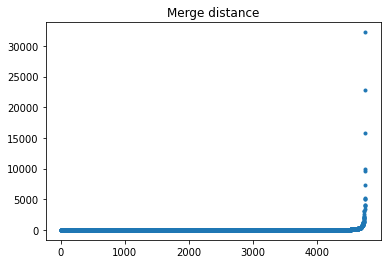

In [15]:
plt.plot(range(1,1+len(childs)), [c[-1] for c in childs], '.')
# plt.yscale('log')
# plt.xscale('log')
plt.title('Merge distance')
plt.show()

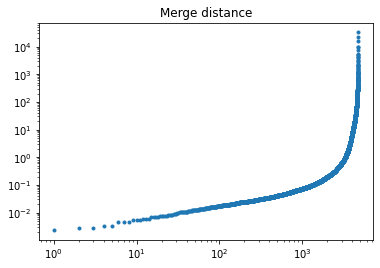

In [16]:
plt.plot(range(1,1+len(childs)), [c[-1] for c in childs], '.')
plt.yscale('log')
plt.xscale('log')
plt.title('Merge distance')
plt.show()

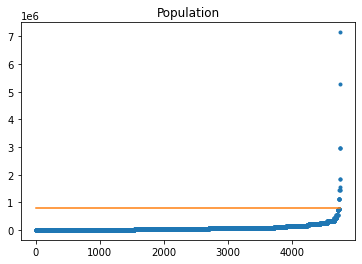

In [17]:
plt.plot(range(1,1+len(childs)), np.maximum.accumulate([c[-2] for c in childs]), '.')
plt.plot([1,1+len(childs)],[group_pops_nz.sum()/9]*2)
# plt.yscale('log')
# plt.xscale('log')
plt.title('Population')
plt.show()

In [18]:
len(childs) - np.argmax( np.maximum.accumulate([c[-2] for c in childs]) > (group_pops_nz.sum()/9))

17

In [19]:
def elbow_plot(data):
    hyp = ( (data[0][0] - data[-1][0])**2 + (data[0][1] - data[-1][0])**2)**0.5
    base = data[-1][0] - data[0][0]
    height = data[-1][1] - data[0][1]
    dists = [ (1-y * hyp**2 / ( (x - data[0][0])*base * height)) * (x - data[0][0])*height / hyp if x > data[0][0] else 0 for x,y in data]
    return np.argmax(dists), dists

def elbow(data):
    hyp = ( (data[0][0] - data[-1][0])**2 + (data[0][1] - data[-1][0])**2)**0.5
    base = data[-1][0] - data[0][0]
    height = data[-1][1] - data[0][1]
    dists = [ (1-y * hyp**2 / ( (x - data[0][0])*base * height)) * (x - data[0][0])*height / hyp if x > data[0][0] else 0 for x,y in data]
    return np.argmax(dists)

def elbow2(data):
    elbowdata = np.array(data)
    if elbowdata.shape[1] != 2:
        elbowdata = elbowdata.T
    elbowdata -= elbowdata[0]
    rotation = np.linalg.inv(np.vstack([elbowdata[-1], [-elbowdata[-1,1], elbowdata[-1,0]]]).T)
    idx = np.argmin((elbowdata @rotation.T)[:,1])
    return idx

In [20]:
elb = elbow(list(enumerate([c[-1] for c in childs])))
print(elb)

4658


In [21]:
dists = np.array([c[-1] for c in childs])
print(len(dists) - elb)

96


In [22]:
def process_children(array, n):
    clusters = {i: group_pops_nz[i] for i in range(len(group_pops_nz))}
    for c in array[:n+1]:
        clusters.pop(c[0])
        clusters.pop(c[1])
        clusters[c[2]] = c[3]
    return clusters

In [23]:
cls = process_children(childs, elb)
cls_pops = np.array(list(cls.values()))

In [24]:
len(group_pops_nz)

4755

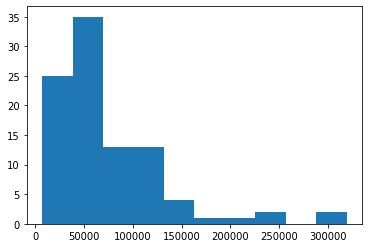

In [25]:
plt.hist(list(cls.values()))
plt.show()

In [26]:
len(cls)

96

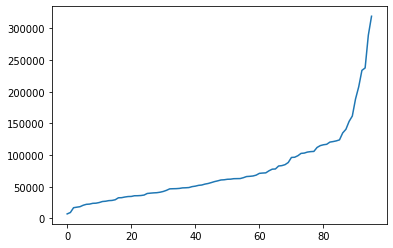

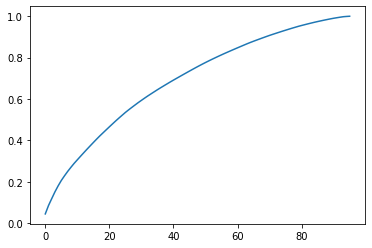

In [27]:
plt.plot(sorted(cls_pops))
plt.show()
plt.plot(np.cumsum(sorted(cls_pops)[::-1]) / cls_pops.sum())
plt.show()

In [28]:
(np.cumsum(sorted(cls_pops)[::-1]) / cls_pops.sum())[:50]

array([0.04460182, 0.08501794, 0.11821349, 0.15087851, 0.17991703,
       0.20625821, 0.22884633, 0.25025386, 0.26991533, 0.28877836,
       0.30611178, 0.32322287, 0.34018196, 0.35702346, 0.37337961,
       0.38963549, 0.40570107, 0.42136072, 0.43614726, 0.45088836,
       0.46553409, 0.4799533 , 0.49430553, 0.50813829, 0.52163839,
       0.53509361, 0.54743283, 0.55929789, 0.57095055, 0.5825228 ,
       0.59343841, 0.6043069 , 0.61482301, 0.62488286, 0.63489684,
       0.64484566, 0.65440449, 0.66377301, 0.67306546, 0.68231037,
       0.69130191, 0.70010258, 0.70888941, 0.71766099, 0.72632868,
       0.73497106, 0.74350423, 0.7519921 , 0.76028784, 0.76841942])

In [29]:
def define_clusters(array, n):
    clusters = {i: {i} for i in range(len(group_pops_nz))}
    for c in array[:n+1]:
        clusters[c[2]] = {*clusters.pop(c[0]), *clusters.pop(c[1])}
    return clusters

In [30]:
cls_members = define_clusters(childs, elb)

In [31]:
import json
np.savez('arizona_coi', codes=group_codes_nz, pops=group_pops_nz, members= cls_members)

In [32]:
big_clusts = sorted(cls_members.values(), key=lambda x: sum(-group_pops_nz[i] for i in x))
def interpret_cluster(clus, n=10):
    vectors = group_std_nz[list(clus)]
    titles = row_titles()
    titles = [t for i,t in enumerate(titles) if np.mean(vectors[:,i]) > 0]
    rel_cols = vectors[:,np.mean(vectors, 0) > 0]
    varis = np.std(rel_cols, axis=0)
    consts = np.argsort(varis)
    
    for i in consts[:n]:
        print(titles[i], ': ', varis[i])
    

In [36]:
def describe_cluster(clus, positive=False):
    rtitles = row_titles()
    cl_mn = np.mean(group_nml_nz[clus].T * group_pops_nz[clus], axis=1) / group_pops_nz[clus].sum()
    cl_std = np.std(group_nml_nz[clus].T * group_pops_nz[clus], axis=1) / group_pops_nz[clus].sum()
    overall_std = np.std(group_nml_nz.T * group_pops_nz, axis=1) / group_pops_nz.sum()
    rat = cl_std / overall_std
    rat[np.argwhere(np.isnan(rat))] = np.inf
    if positive:
        rat[cl_mn == 0] = np.inf
    ttypes = title_types()
    overall_mean = group_nml_nz.mean(0)
    for i,t in enumerate(rtitles):
        if ttypes[t] == 'BOOL':
            #pass
            rat[i] = 1-cl_mn[i]
    print('Population: ', group_pops_nz[clus].sum())
    return sorted(zip(rtitles, rat, cl_mn, overall_mean), key=lambda x: x[1])


def describe_cluster2(clus, positive=False):
    rtitles = row_titles()
    cl_mn = (group_nml_nz[clus].T @ group_pops_nz[clus]) / group_pops_nz[clus].sum()
    overall_mn = (group_nml_nz.T @ group_pops_nz) / group_pops_nz.sum()
    rat = abs(cl_mn - overall_mn)
    ttypes = title_types()
    print('Population: ', group_pops_nz[clus].sum())
    return sorted(zip(rtitles, rat, cl_mn, overall_mn), key=lambda x: -x[1])



In [38]:
describe_cluster(list(big_clusts[0]), positive=True)[:30]

Population:  318970


[('PLACE 20540',
  1.5191345612967426,
  1.4479336287369752e-06,
  0.002945802398418298),
 ('PLACE 60120',
  1.5674961731557377,
  6.04354905907607e-07,
  0.0007217795406022731),
 ('% PI/AK (18+)',
  1.8467185561148718,
  7.557422909462941e-05,
  0.047864608336049844),
 ('% INDIAN', 1.9135695108765363, 7.952303303567595e-05, 0.0491843444785444),
 ('% OTHER (HISP&18+)',
  2.1856336161185133,
  6.906890961789907e-05,
  0.05311950260661541),
 ('% ASIAN (HISP)',
  2.2829900716044538,
  7.450014724408693e-05,
  0.05588992564689861),
 ('SDUNI 08850',
  2.2979392829541134,
  3.651310889858459e-06,
  0.0071336892538335795),
 ('SDUNI 01760',
  2.4658168223175543,
  2.0145163530253566e-06,
  0.0053123686831248245),
 ('CBSAPCI N', 2.8568948321577166, 6.605095492481887e-05, 0.3843600515206502),
 ('LATITUDE', 4.434292016207274, 0.0006296115824051297, 0.3626220653321356),
 ('SDUNI 00680',
  4.609518887779668,
  1.406384228955827e-05,
  0.02254970106096696),
 ('PLACE 99999', 5.342684716321039, 1.9452

In [34]:
describe_cluster2(list(big_clusts[0]), positive=False)[:30]

Population:  318970


[('SDUNI 08800', 0.9212863226881637, 0.9885882684891996, 0.06730194580103592),
 ('PLACE 77000', 0.9028333679956297, 0.9787095965137788, 0.07587622851814906),
 ('COUSUB 93570', 0.8734510596515249, 1.0, 0.12654894034847505),
 ('COUNTY 19.0', 0.8540959647357995, 1.0, 0.14590403526420045),
 ('CSA 536', 0.8474303719694128, 1.0, 0.15256962803058713),
 ('CSA 429', 0.6850454631768264, 0.0, 0.6850454631768264),
 ('COUNTY 13.0', 0.6181314079196231, 0.0, 0.6181314079196231),
 ('COUSUB 92601', 0.4659056237416979, 0.0, 0.4659056237416979),
 ('CBSAPCI Y', 0.43598906032431817, 0.9787095965137788, 0.5427205361894606),
 ('CBSAPCI N', 0.37640924654353153, 0.0164466877762799, 0.3928559343198114),
 ('SDELM 99999', 0.3349264252460532, 1.0, 0.6650735747539468),
 ('SDUNI 99999', 0.3349264252460532, 0.0, 0.3349264252460532),
 ('SDSEC 99999', 0.32002731733837175, 1.0, 0.6799726826616282),
 ('PLACE 55000', 0.22486730759496396, 0.0, 0.22486730759496396),
 ('LATITUDE', 0.20283607183356187, 0.15677328401887733, 0.

In [58]:
with codecs.open('aznames/NAMES_ST04_AZ_SDUNI.txt', 'r', 'latin-1') as file:
    sduni = pd.read_csv(file,sep='|', keep_default_na=False)
with codecs.open('aznames/NAMES_ST04_AZ_INCPLACE.txt', 'r', 'latin-1') as file:
    place = pd.read_csv(file,sep='|', keep_default_na=False)    

In [59]:
sduni[sduni['DISTRICT']==8800]

,STATEFP,DISTRICT,NAME,NAMELSAD
88,4,8800,Tucson Unified District,Tucson Unified District


In [61]:
block_data[block_data['SDUNI']==8800]['POP100'].sum()

481310

In [180]:
rtitles = row_titles()
bc = group_nml_nz[list(big_clusts[0])]


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00164485],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01030781],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0057433 ]])

In [183]:
rtitles.index('SDUNI 7520')

936

In [184]:
bc[:,rtitles.index('SDUNI 7520')]

array([0.94710327, 0.95049791, 0.94710327, 0.94710327, 0.94710327,
       0.94774063, 0.94710327, 0.94776099, 0.94909802, 0.94896888,
       0.94710327, 0.94782958, 0.94710327, 0.94710327, 0.94710327,
       0.94765105, 0.94710327, 0.94710327, 0.94710327, 0.94710327,
       0.94710327, 0.94769117, 0.94710327, 0.94775826, 0.9488232 ,
       0.93830276, 0.94781378, 0.9478246 , 0.94828347, 0.95056744,
       0.94710327, 0.94758872, 0.9480648 , 0.94764947, 0.948609  ,
       0.94746054, 0.94768042, 0.95236496, 0.94754772, 0.94710327,
       0.94710327, 0.94754834, 0.94843348, 0.9482842 , 0.94776328,
       0.94710327, 0.94798022, 0.94766336, 0.94766469, 0.94710327,
       0.94710327, 0.94769337, 0.94864161, 0.94877169, 0.94763386,
       0.9538804 , 0.94710327, 0.9492509 , 0.94710327, 0.94842789,
       0.94805802, 0.94889026, 0.96862835, 0.94871674, 0.94808169,
       0.95053481, 0.95008784, 0.94784262, 0.9475444 , 0.94710327,
       0.9499377 , 0.94775826, 0.9596017 , 0.6063771 , 0.95408

In [234]:
gps = block_groups[block_groups['GEOCODE'].isin([group_codes_nz[i] for i in big_clusts[0]])]
gps

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,CIFSN,LOGRECNO,GEOID,GEOCODE,...,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
3912,PLST,AZ,150,0,0,0,0,3913,1500000US040133193002,040133193002,...,10,0,0,0,0,0,10,0,0,10
4007,PLST,AZ,150,0,0,0,0,4008,1500000US040134201113,040134201113,...,0,0,0,0,0,0,0,0,0,0
4011,PLST,AZ,150,0,0,0,0,4012,1500000US040134201132,040134201132,...,0,0,0,0,0,0,0,0,0,0
4012,PLST,AZ,150,0,0,0,0,4013,1500000US040134201141,040134201141,...,0,0,0,0,0,0,0,0,0,0
4013,PLST,AZ,150,0,0,0,0,4014,1500000US040134201142,040134201142,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,PLST,AZ,150,0,0,0,0,4368,1500000US040134226382,040134226382,...,53,53,0,0,53,0,0,0,0,0
4370,PLST,AZ,150,0,0,0,0,4371,1500000US040134226393,040134226393,...,0,0,0,0,0,0,0,0,0,0
4397,PLST,AZ,150,0,0,0,0,4398,1500000US040134226532,040134226532,...,7,0,0,0,0,0,7,0,0,7
4412,PLST,AZ,150,0,0,0,0,4413,1500000US040134226601,040134226601,...,63,0,0,0,0,0,63,0,0,63


In [235]:
gps['POP100'].sum()

266900

In [211]:
def get_blocks_for_group(group):
    blocks = census_data[census_data['SUMLEV']==750]
    county_blocks = blocks[blocks['COUNTY']==group['COUNTY']]
    tract_blocks = county_blocks[county_blocks['TRACT']==group['TRACT']]
    group_blocks = tract_blocks[tract_blocks['BLKGRP']==group['BLKGRP']]
    return group_blocks

In [236]:
bg_blocks = []
for i,g in gps.iterrows():
    bg_blocks.append(get_blocks_for_group(g))

In [220]:
for (i,gp),blks in zip(gps.iterrows(), bg_blocks):
    if gp['POP100'] != blks['POP100'].sum():
        print(i, gp['POP100'], blks['POP100'].sum())

In [229]:
sduni_pops = {}
total_pop = 0
for blklist in bg_blocks:
    for i,blk in blklist.iterrows():
        sduni_pops[blk['SDUNI']] = sduni_pops.get(blk['SDUNI'],0) + blk['POP100']
        total_pop += blk['POP100']
        
print(sduni_pops)

{99999: 93646, 7170: 1217, 2690: 217, 9190: 0, 6250: 6293, 7570: 8138, 99997: 100, 4970: 127454, 3400: 10851, 6810: 4821, 3780: 8429, 1870: 5248, 7750: 4117, 3310: 22}


In [230]:
sorted(sduni_pops.items(), key=lambda x: -x[1])

[(4970, 127454),
 (99999, 93646),
 (3400, 10851),
 (3780, 8429),
 (7570, 8138),
 (6250, 6293),
 (1870, 5248),
 (6810, 4821),
 (7750, 4117),
 (7170, 1217),
 (2690, 217),
 (99997, 100),
 (3310, 22),
 (9190, 0)]

In [251]:
blkgp_info = get_info(bg_blocks[0])

In [262]:
x = np.linalg.norm(blkgp_info - group_mat_nz, axis=1)
print(min(x))
print(np.argmin(x))
print(list(big_clusts[0])[0])

3.8543451451486357
1887
1046


In [254]:
rts = row_titles()
print(blkgp_info[rts.index('SDUNI 4970')])
print(blkgp_info[rts.index('SDUNI 7520')])

0.6358885017421603
0.0


In [200]:
group= gps.iloc[0]
print(group)
print('Blocks')
blocks = census_data[census_data['SUMLEV']==750]
print(blocks)
print('County ', group['COUNTY'])
county_blocks = blocks[blocks['COUNTY']==int(group['COUNTY'])]
print(county_blocks['COUNTY'])
print('Tract ', group['TRACT'])
tract_blocks = county_blocks[county_blocks['TRACT']==int(group['TRACT'])]
print(tract_blocks['TRACT'])
print('Group ', group['BLKGRP'])
group_blocks = tract_blocks[tract_blocks['BLKGRP']==int(group['BLKGRP'])]
print(group_blocks['BLKGRP'])
print()

FILEID      PLST
STUSAB        AZ
SUMLEV       150
GEOVAR         0
GEOCOMP        0
            ... 
P0050006       0
P0050007       0
P0050008       0
P0050009       0
P0050010       0
Name: 2381, Length: 413, dtype: object
Blocks
       FILEID STUSAB  SUMLEV GEOVAR  GEOCOMP  CHARITER  CIFSN  LOGRECNO  \
57730    PLST     AZ     750      0        0         0      0     57731   
57731    PLST     AZ     750      0        0         0      0     57732   
57732    PLST     AZ     750      0        0         0      0     57733   
57733    PLST     AZ     750      0        0         0      0     57734   
57734    PLST     AZ     750      0        0         0      0     57735   
...       ...    ...     ...    ...      ...       ...    ...       ...   
213169   PLST     AZ     750      0        0         0      0    213170   
213170   PLST     AZ     750      0        0         0      0    213171   
213171   PLST     AZ     750      0        0         0      0    213172   
213172   PLST    

In [202]:
group_blocks['POP100'].sum()

1412

In [203]:
group['POP100']

1412

In [250]:
block_groups = census_data[census_data['SUMLEV']==150]

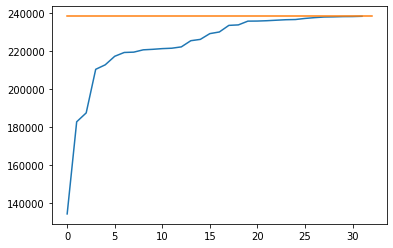

In [163]:
plt.plot(sorted([c.population for c in flat_clusts_ld.values()]))
plt.plot([0,len(flat_clusts_ld)],[sum(group_pops_nz)/30]*2)

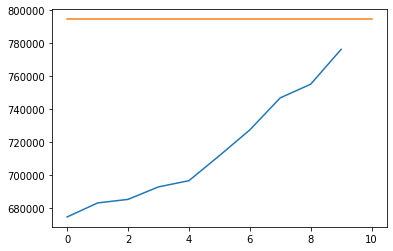

In [164]:
plt.plot(sorted([c.population for c in flat_clusts_cd.values()]))
plt.plot([0,len(flat_clusts_cd)],[sum(group_pops_nz)/9]*2)

In [165]:
np.savez('arizona_ld_cluster', mat=group_std_nz, pops=group_pops_nz, children=wag_ld.children_, geocodes=group_codes_nz)
np.savez('arizona_cd_cluster', mat=group_std_nz, pops=group_pops_nz, children=wag_cd.children_, geocodes=group_codes_nz)

In [145]:
len(flat_clusts_cd)

10

In [158]:
arizona_cd = balance2(flat_clusts_cd, 9)

In [11]:
np.savez('arizona_clusters', clusters=clusts)

In [16]:
wag = WeightedAgglomerativeClustering()
small_clust = wag.fit(group_std[clusts[18788]['members']], group_pops[clusts[18788]['members']])

c:\users\patri\miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
c:\users\patri\miniconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


In [27]:
smcl = clusts[smclts[-1]]
smcl

{'members': [6624,
  6625,
  6626,
  6627,
  6628,
  6629,
  6630,
  6631,
  6632,
  6633,
  6644,
  6645,
  6646,
  6647,
  6634,
  6635,
  6636,
  6637,
  6642,
  6643,
  6638,
  6639,
  6640,
  6641,
  6598,
  6599,
  6600,
  6601,
  6602,
  6603,
  6608,
  6609,
  6604,
  6605,
  6606,
  6607,
  6614,
  6615,
  6610,
  6611,
  6612,
  6613,
  6616,
  6617,
  6618,
  6619,
  6620,
  6621,
  6622,
  6623,
  6656,
  6657,
  6658,
  6659,
  6648,
  6649,
  6650,
  6651,
  6652,
  6653,
  6654,
  6655,
  6664,
  6665,
  6660,
  6661,
  6662,
  6663,
  6670,
  6671,
  6672,
  6673,
  6666,
  6667,
  6668,
  6669,
  6686,
  6687,
  6682,
  6683,
  6684,
  6685,
  6678,
  6679,
  6680,
  6681,
  6674,
  6675,
  6676,
  6677,
  6688,
  6689,
  6690,
  6691,
  6692,
  6693,
  6694,
  6695,
  6696,
  6697,
  6698,
  6699,
  6700,
  6701,
  6702,
  6703,
  6704,
  6705,
  6706,
  6707,
  6708,
  6709,
  3708,
  3709,
  3710,
  3711,
  3712,
  3713,
  3714,
  3715,
  3716,
  3717,
  3692,
  369

In [160]:
np.blastoise = balance2

In [23]:
group_data.iloc[3940]['POP100']

0

In [28]:
group_data[group_data['POP100']==0]

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,CIFSN,LOGRECNO,GEOID,GEOCODE,...,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
48283,PLST,AZ,740,0,0,0,0,48284,7400000US0400100000591275999999705023,0400100000591275999999705023,...,0,0,0,0,0,0,0,0,0,0
48295,PLST,AZ,740,0,0,0,0,48296,7400000US0400100001090612999999443011,0400100001090612999999443011,...,0,0,0,0,0,0,0,0,0,0
48297,PLST,AZ,740,0,0,0,0,48298,7400000US0400100001091326999999440001,0400100001091326999999440001,...,0,0,0,0,0,0,0,0,0,0
48304,PLST,AZ,740,0,0,0,0,48305,7400000US0400100001590612999999443022,0400100001590612999999443022,...,0,0,0,0,0,0,0,0,0,0
48305,PLST,AZ,740,0,0,0,0,48306,7400000US0400100002092805999999451002,0400100002092805999999451002,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57706,PLST,AZ,740,0,0,0,0,57707,7400000US04027000P3893978999990001001,04027000P3893978999990001001,...,0,0,0,0,0,0,0,0,0,0
57707,PLST,AZ,740,0,0,0,0,57708,7400000US04027000P3993978855400005011,04027000P3993978855400005011,...,0,0,0,0,0,0,0,0,0,0
57712,PLST,AZ,740,0,0,0,0,57713,7400000US04027000P3993978999990005011,04027000P3993978999990005011,...,0,0,0,0,0,0,0,0,0,0
57713,PLST,AZ,740,0,0,0,0,57714,7400000US04027000P3993978999990006005,04027000P3993978999990006005,...,0,0,0,0,0,0,0,0,0,0


In [29]:
group_data

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,CIFSN,LOGRECNO,GEOID,GEOCODE,...,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
48281,PLST,AZ,740,0,0,0,0,48282,7400000US0400100000591071019209705021,0400100000591071019209705021,...,0,0,0,0,0,0,0,0,0,0
48282,PLST,AZ,740,0,0,0,0,48283,7400000US0400100000591071999999705021,0400100000591071999999705021,...,0,0,0,0,0,0,0,0,0,0
48283,PLST,AZ,740,0,0,0,0,48284,7400000US0400100000591275999999705023,0400100000591275999999705023,...,0,0,0,0,0,0,0,0,0,0
48284,PLST,AZ,740,0,0,0,0,48285,7400000US0400100001090612127709442011,0400100001090612127709442011,...,0,0,0,0,0,0,0,0,0,0
48285,PLST,AZ,740,0,0,0,0,48286,7400000US0400100001090612127709442021,0400100001090612127709442021,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57725,PLST,AZ,740,0,0,0,0,57726,7400000US04027000P4293978999990009071,04027000P4293978999990009071,...,0,0,0,0,0,0,0,0,0,0
57726,PLST,AZ,740,0,0,0,0,57727,7400000US04027000P4293978999990009072,04027000P4293978999990009072,...,0,0,0,0,0,0,0,0,0,0
57727,PLST,AZ,740,0,0,0,0,57728,7400000US04027000P4293978999990009074,04027000P4293978999990009074,...,0,0,0,0,0,0,0,0,0,0
57728,PLST,AZ,740,0,0,0,0,57729,7400000US04027000P4393264855400118012,04027000P4393264855400118012,...,0,0,0,0,0,0,0,0,0,0


In [30]:
group_data_nz = group_data[group_data['POP100'] > 0]
group_pops_nz = np.array(group_data_nz['POP100'].array)
group_std_nz = group_std[[i for i in range(len(group_std)) if group_data.iloc[i]['POP100'] > 0]]

In [ ]:
wag = WeightedAgglomerativeClustering(30)
clusts_nz = wag.fit(group_std_nz, group_pops_nz)